# Out-of-DIstribution detector for Neural networks (ODIN) with mobilenet

The goal of this notebook is to understand [Enhancing The Reliability of Out-of-distribution Image Detection in Neural Networks](https://arxiv.org/abs/1706.02690). We transform a trained classifier into a out-of-distribution detector. Here, we will take a small mobilenet neural network trained on CIFAR10 and see how to use it to make a detector for out-of-distirbution samples obtianed by cropping images from the ImageNet dataset.

The image below is taken from the original paper and shows the performances obtained with the ODIN method on DenseNet-BC-100 network.
![](https://raw.githubusercontent.com/ShiyuLiang/odin-pytorch/master/figures/original_optimal_shade.png)

A detector is a binary classifier thath needs to output $1$ when the input image is from the in-distribution (CIFAR10) and $0$ when the input image is from the out-distribution (ImageNet-crop).
TPR on CIFAR10 is then the probability that the detector is correct on an image from CIFAR10 and FPR on TinyImagenNet (crop) is the probability that the detector is not correct on an image from ImageNet-crop.
As in binary classification, we aim at maximizing TPR while minimizing FPR and the tradeoff between these two goals is capured by a ROC curve (shown above).

In this practical, we derive ROC curves for the ODIN methods with the mobilenet network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mobilenet for CIFAR10

We will use a pretrained model called [Mobilenet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) which is an efficient network optimized for speed and memory, with [residual blocks](https://dataflowr.github.io/website/modules/17-resnets/). The default version from `torch.vision` is pretrained on Imagenet so we will rely on the version provided by [PyTorch_CIFAR10](https://github.com/huyvnphan/PyTorch_CIFAR10) which was trained on CIFAR10.

The code below allows you to download the weights of the neural network and the [piece of code](https://github.com/dataflowr/notebooks/blob/master/Module17/mobilenetv2.py) that will be useful for us (without cloning the whole repo above).

In [2]:
# the code below downloads the weights of the neural net and should be run only once.
# You can uncomment it and run it, the first time you are using it or if you are running on colab.
#%mkdir state_dicts
#%cd state_dicts/
#!wget https://www.di.ens.fr/~lelarge/mobilenet_v2.pt
#%cd ..

In [3]:
# if on colab first uncomment and run the following command (only once):
#!wget https://raw.githubusercontent.com/dataflowr/notebooks/master/Module17/mobilenetv2.py

In [4]:
from mobilenetv2 import mobilenet_v2

model = mobilenet_v2(pretrained=True)
model.eval()
model.to(DEVICE)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
NORM_BIAS = [125.3 / 255, 123.0 / 255, 113.9 / 255]
NORM_SCALE = [63.0 / 255, 62.1 / 255.0, 66.7 / 255.0]
EPS_FSGM = 1e-2
IMAGE_SIZE = (32, 32)
batch_size = 64

#%mkdir data

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(NORM_BIAS, NORM_SCALE),
        transforms.Resize(IMAGE_SIZE),
    ]
)

testset = torchvision.datasets.CIFAR10(root="./data/", train=False, download=True, transform=transform)
testloaderIn = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


## Question 1: test your network

Use the code from the [course](https://dataflowr.github.io/website/modules/5-stacking-layers/) (when we did overfit a MLP on CIFAR10) in order to get the performance of the pretrained network on CIFAR10 test set.

The dataloader is given to you above.

In [7]:
def test(model, test_loader, device = DEVICE):
    model.eval()
    test_correct = 0
    test_l =0
    for i, (batch, targets) in enumerate(test_loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        targets = targets.to(device)
        output = model(batch)
        pred = output.max(1, keepdim=True)[1]
        test_correct += pred.eq(targets.view_as(pred)).sum().item()
        test_l += bs
    
    print('End of testing. Test accuracy {:.2f}%'.format(
    100 * test_correct / test_l))

In [8]:
test(model, testloaderIn)

End of testing. Test accuracy 93.91%


## Out-of-distribution Dataset

The code below allows you to download the out-of-distribution dataset.
You should not modify this code.

In [9]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(NORM_SCALE * inp + NORM_BIAS, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [10]:
batchIn = next(iter(testloaderIn))

In [11]:
imgIn = batchIn[0]
imgIn = torch.narrow(imgIn, 0, 0, 32)

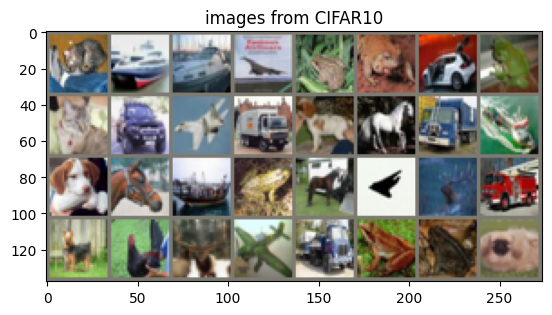

In [12]:
im_in = torchvision.utils.make_grid(imgIn)

imshow(im_in,title='images from CIFAR10')

In [13]:
CIFAR10_labels = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']
preds = model(imgIn.to(DEVICE)).max(1, keepdim=True)[1]
[CIFAR10_labels[pred] for pred in preds]

['cat',
 'ship',
 'ship',
 'ship',
 'frog',
 'frog',
 'automobile',
 'frog',
 'cat',
 'automobile',
 'airplane',
 'truck',
 'dog',
 'horse',
 'truck',
 'ship',
 'dog',
 'horse',
 'ship',
 'frog',
 'horse',
 'airplane',
 'deer',
 'truck',
 'dog',
 'bird',
 'deer',
 'airplane',
 'truck',
 'frog',
 'frog',
 'dog']

In [14]:
# The code below dowload the out-of-distribution dataset
# if on colab first uncomment and run the following command (only once):
#%cd data
#!wget https://www.dropbox.com/s/avgm2u562itwpkl/Imagenet.tar.gz
#!tar -xvzf Imagenet.tar.gz
#%cd ..

In [15]:
testsetout = torchvision.datasets.ImageFolder("./data/Imagenet/", transform=transform)
testloaderOut = DataLoader(testsetout, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
batchOut = next(iter(testloaderOut))

In [17]:
imgOut = batchOut[0]
imgOut = torch.narrow(imgOut, 0, 0, 32)

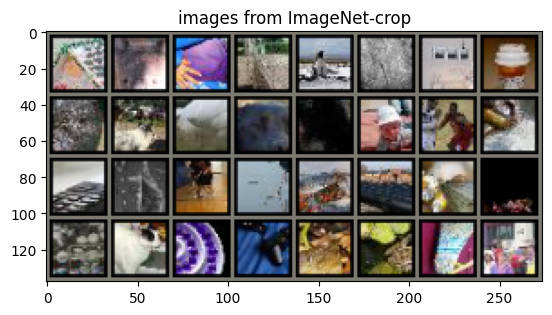

In [18]:
im_out = torchvision.utils.make_grid(imgOut)

imshow(im_out, title='images from ImageNet-crop')

We have now two dataloaders `testloaderIn` and `testloaderOut` corresponding to the in- and out-distribution, and our mobilenet network `model`. 

# Out-of-distribution Detector

Our network `model` has been trained on CIFAR10 and hence outputs a vetor of size 10 representing the logprobs of being one of the 10 classes of CIFAR10. To use our model as a detector, we need to transform this output into a single value corresponding to the probability of being from the in-distribution. Hence, we want this output to be high for images from CIFAR10 and low for images from ImageNet-crop.

## Temperature scaling

The first method proposed in [ODIN](https://arxiv.org/abs/1706.02690) relies on the fact that the trained network should be more confident on images from the in-distribution than on images form the out-distribution.

For an image ${\bf x}$, let $f({\bf x}) = (f_1({\bf x}),\dots, f_C({\bf x}))\in \mathbb{R}^C$ be the output of the network, where $C$ is the number of classes. We define for a temperature scaling parameter $T>0$,
\begin{eqnarray*}
S_i({\bf x},T) = \frac{\exp(f_i({\bf x})/T)}{\sum_{j=1}^C \exp(f_j({\bf x})/T)}\geq 0,
\end{eqnarray*}
so that $\sum_i S_i({\bf x},T)=1$. The **softmax score** is then $\max_i S_i({\bf x},T)$.

We expect the softmax score to be higher for images from the in-distribution than for images from the out-distribution. Hence we can build a classifier based on this score.

## Question 2: compute the softmax score

Compute the softmax scores with $T=1$ and $T=1000$ and plot the corresponding ROC curves (using [`metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)).

Hint: to get a picture similar to the one in the paper shown above use `plt.ylim(0.8, 1.002)`.

In [19]:
# this function takes a model, an algorithm and a dataloader and compute all the corresponding scores
# To use this function your algorithm needs to have a method apply taking as input 
# a batch and the model in order to compute the scores for the batch
def compute_scores(model, algo, loader, device=DEVICE):
    model.eval()
    all_scores = []
    for i, (batch, targets) in enumerate(loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        scores = algo.apply(batch, model)
        all_scores += scores
    return all_scores
# You can test your method apply by running commands like:
# name_of_your_algo.apply(imgIn.to(DEVICE), model)
# name_of_your_algo.apply(imgOut.to(DEVICE), model)
# to obtain the scores on the small batchs made above.

In [20]:
softmax_score = lambda x, t: torch.max(torch.softmax(x / t, dim=-1), dim=-1).values.detach().cpu().numpy()

In [21]:
class BaseAlgorithm():
    def __init__(self, temperature: float = 1.0):
        self.temperature = temperature
        self.function = softmax_score #lambda x, t: torch.max(torch.softmax(x / t, dim=-1), dim=-1).values

    @torch.no_grad()
    def apply(self, images, net):
        outputs = net(images)
        scores = self.function(outputs, self.temperature)
        return [s.item() for s in scores]

In [22]:
base = BaseAlgorithm(temperature=1.)

In [23]:
scores_In = compute_scores(model, base, testloaderIn)
scores_Out = compute_scores(model, base, testloaderOut)

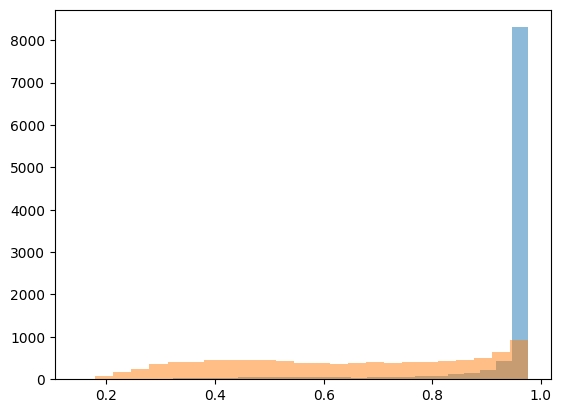

In [24]:
plt.hist(scores_In, bins = 25, alpha=0.5);
plt.hist(scores_Out, bins = 25, alpha=0.5);

In [25]:
y = np.array([1]*len(scores_In)+[0]*len(scores_Out))
scores = scores_In+scores_Out
fpr, tpr, thresholds = metrics.roc_curve(y, scores)

In [26]:
base1 = BaseAlgorithm(temperature=1000.)
scores_In1 = compute_scores(model, base1, testloaderIn)
scores_Out1 = compute_scores(model, base1, testloaderOut)
scores1 = scores_In1+scores_Out1
fpr1, tpr1, thresholds1 = metrics.roc_curve(y, scores1)

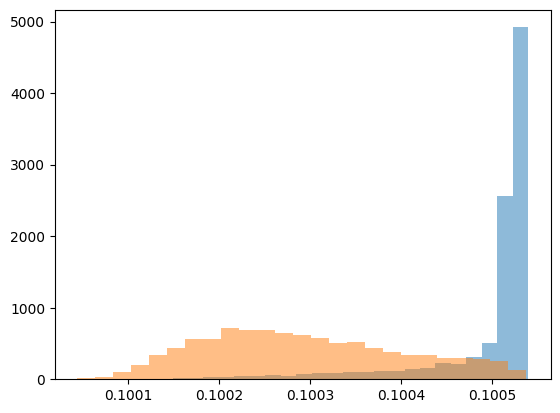

In [27]:
plt.hist(scores_In1, bins = 25, alpha=0.5);
plt.hist(scores_Out1, bins = 25, alpha=0.5);

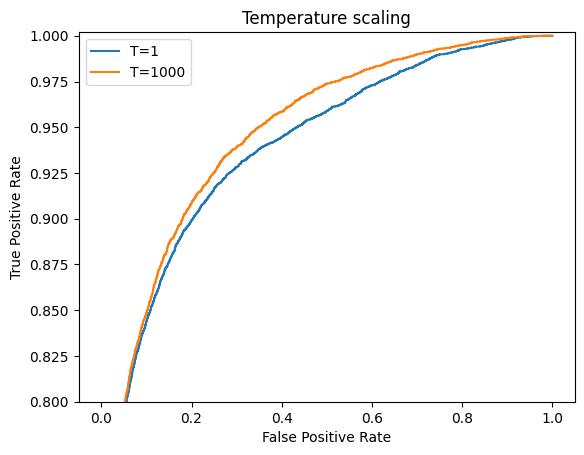

In [28]:
plt.plot(fpr, tpr, label ='T=1')
plt.plot(fpr1, tpr1, label='T=1000')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0.8, 1.002)
plt.title('Temperature scaling')
plt.legend();

## Input preprocessing

The second method relies on perturbing the imput image. The main idea is to perturb the image in order to increase its softmax score as follows:
\begin{eqnarray*}
\tilde{\bf x} = {\bf x} - \epsilon \text{sign}\left( -\nabla_{\bf x} \log S_{\hat{y}}({\bf x},T)\right),
\end{eqnarray*}
where $\hat{y} =\arg\max_i S_i({\bf x},T)$ and $\epsilon>0$ is the noise magnitude applied on the image.
This perturbation should have a much higher impact on CIFAR10 images (in-distribution) than on ImageNet images (out-distribution) making the detection easier.

This second method can be used with the temperature scaling (this is why we keep the parameter $T$ in the formula above). Note that this method does not require the label of the image, as a result it can be applied to in-domain images as well as out-of domain images. The gradient can be computed with a standard [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) but note that the gradient is taken with respect to the pixels of the image not the weights of the neural network which are untouched. A similar technique has been used in [adversarial attacks](https://dataflowr.github.io/website/homework/2-CAM-adversarial/) where the goal was to perturb the image in order to fool the prediction made by the neural network.

## Question 3: code the perturbation on the image and the ODIN algorithm with both perturbation and temperature scaling.

Hints: 
- make a clone of the images and make it differentiable: 
```
inputs = images.clone()
inputs.requires_grad=True
```
- compute the label with `argmax`, the loss and do the backpropagation.
- compute the sign of the gradient with [`torch.ge`](https://pytorch.org/docs/stable/generated/torch.ge.html#torch-ge) for example to get your binary gradient
- remember that the images are first scaled with `NORM_SCALE`, hence divide your binary gradient by these quantity in order to implement exactly the algorithm described above (and to get better results!).
- for the ODIN algorithm creat a class as you did above with a `apply` method so that you can reuse your code for computing scores. You can test your algo with commands like
```
scores_In_odin = odin.apply(imgIn.to(DEVICE), model)
scores_Out_odin = odin.apply(imgOut.to(DEVICE), model)
```

Plot the resulting ROC curves.

In [29]:
from dataclasses import dataclass
@dataclass
class Attacker:
    """Use an epsilon attack on the image
    Makes the most likely class more likely 
    by eps*sign(grad(-logprob_class))."""

    temperature: float
    noiseMagnitude: float
    iters: int = 1
    criteria = torch.nn.CrossEntropyLoss()
    

    def attack(self, images, net):
        inputs = images.clone()
        inputs.requires_grad=True
        for _ in range(self.iters):
            outputs = net(inputs)
            labels = torch.argmax(outputs, dim=1)
            # Using temperature scaling
            outputs = outputs / self.temperature
            loss = self.criteria(outputs, labels)
            loss.backward()

            # Normalizing the gradient to binary in {0, 1}
            gradient = torch.ge(inputs.grad.data, 0)
            gradient = (gradient.float() - 0.5) * 2
            # Normalizing the gradient to the same space of image
            norm_scale = torch.tensor(NORM_SCALE, device=gradient.device).view(1, 3, 1, 1)
            gradient /= norm_scale
            # Adding small perturbations to images
            inputs.data = torch.add(inputs.data, gradient, alpha=-self.noiseMagnitude / self.iters)
            inputs.grad.zero_

        return inputs.data

In [30]:
class OdinAlgorithm():
    def __init__(
        self,
        temperature: float = 1000,
        noiseMagnitude: float = 0.0012,
        iters: int = 1,
    ):
        self.attacker = Attacker(temperature, noiseMagnitude, iters)
        self.temperature = temperature

    def apply(self, images, net):
        inputs = self.attacker.attack(images, net)

        with torch.no_grad():
            outputs = net(inputs)
            # Calculating the softmax score after adding perturbations
            nnOutputs = softmax_score(outputs, self.temperature)
            return [nnOutputs[i] for i in range(len(nnOutputs))]

In [31]:
odin = OdinAlgorithm(temperature = 1., noiseMagnitude=0.0012, iters=1)
scores_In_odin = compute_scores(model, odin, testloaderIn)
scores_Out_odin = compute_scores(model, odin, testloaderOut)

In [32]:
scores_odin = scores_In_odin+scores_Out_odin
fpr_odin, tpr_odin, thresholds_odin = metrics.roc_curve(y, scores_odin)

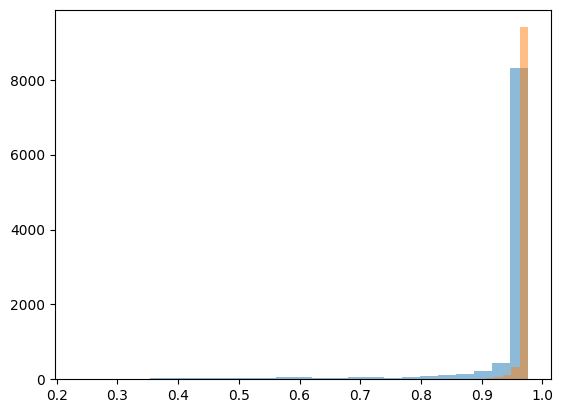

In [33]:
plt.hist(scores_In, bins = 25, alpha=0.5)
plt.hist(scores_In_odin, bins = 25, alpha=0.5);

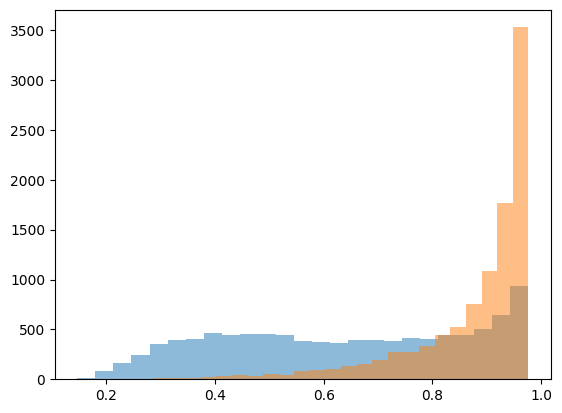

In [34]:
plt.hist(scores_Out, bins = 25, alpha=0.5)
plt.hist(scores_Out_odin, bins = 25, alpha=0.5);

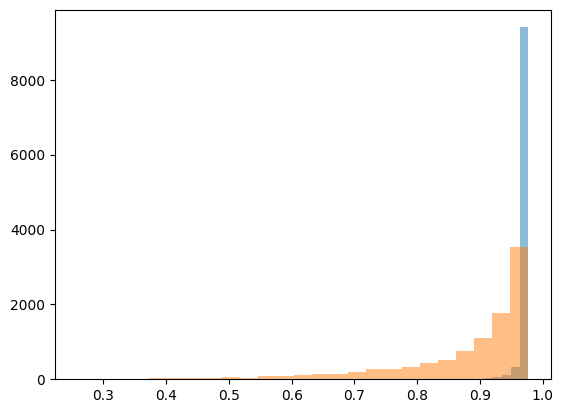

In [35]:
plt.hist(scores_In_odin, bins = 25, alpha=0.5);
plt.hist(scores_Out_odin, bins = 25, alpha=0.5);

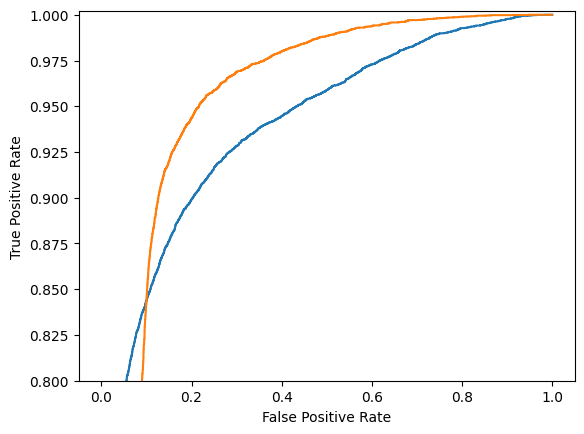

In [36]:
plt.plot(fpr, tpr)
plt.plot(fpr_odin, tpr_odin)
plt.ylim(0.8, 1.002)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [37]:
odin1 = OdinAlgorithm(temperature = 1000., noiseMagnitude=0.0012, iters=1)

In [38]:
scores_In_odin1 = compute_scores(model, odin1, testloaderIn)
scores_Out_odin1 = compute_scores(model, odin1, testloaderOut)

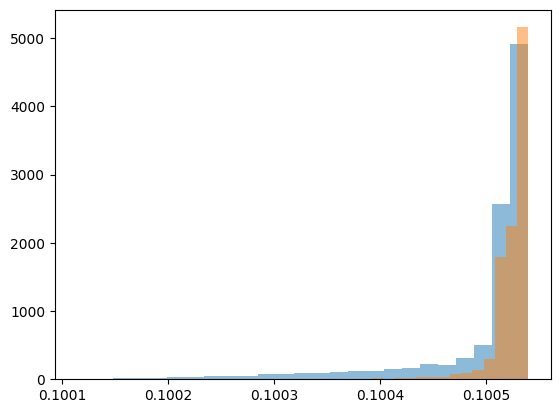

In [39]:
plt.hist(scores_In1, bins = 25, alpha=0.5)
plt.hist(scores_In_odin1, bins = 25, alpha=0.5);

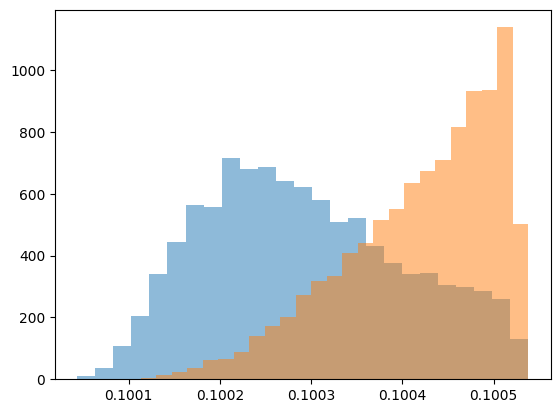

In [40]:
plt.hist(scores_Out1, bins = 25, alpha=0.5)
plt.hist(scores_Out_odin1, bins = 25, alpha=0.5);

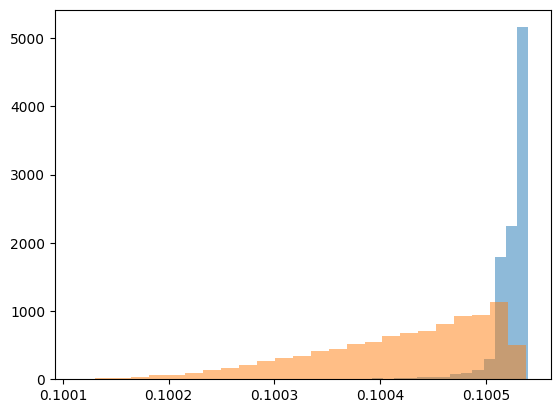

In [41]:
plt.hist(scores_In_odin1, bins = 25, alpha=0.5);
plt.hist(scores_Out_odin1, bins = 25, alpha=0.5);

In [42]:
scores_odin1 = scores_In_odin1+scores_Out_odin1
fpr_odin1, tpr_odin1, thresholds_odin1 = metrics.roc_curve(y, scores_odin1)

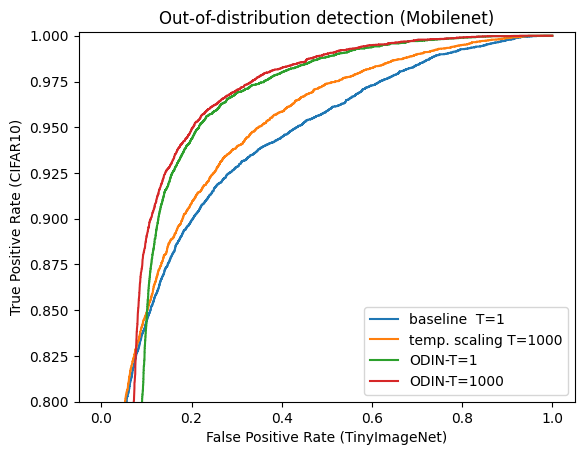

In [43]:
plt.plot(fpr, tpr, label ='baseline  T=1')
plt.plot(fpr1, tpr1, label ='temp. scaling T=1000')
plt.plot(fpr_odin, tpr_odin, label ='ODIN-T=1')
plt.plot(fpr_odin1, tpr_odin1, label ='ODIN-T=1000')
plt.ylim(0.8, 1.002)
plt.xlabel('False Positive Rate (TinyImageNet)')
plt.ylabel('True Positive Rate (CIFAR10)')
plt.title('Out-of-distribution detection (Mobilenet)')
plt.legend();